Материалы вебинара:

# Import libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

## Read data

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# Process features dataset

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [4]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [5]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [6]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [7]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [8]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [9]:
# выше видим разброс по пользователям и товарам

In [10]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [11]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\Users\WiZor\Jupyter\Recommendations systems\HW\HW6\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [12]:
# ищем общих пользователей
common_users = list(set(data_train_matcher.user_id.values)&(set(data_val_matcher.user_id.values))&set(data_val_ranker.user_id.values))

data_train_matcher = data_train_matcher[data_train_matcher.user_id.isin(common_users)]
data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (784420, 13) Users: 1915 Items: 4999
val_matcher
Shape: (163261, 12) Users: 1915 Items: 27118
train_ranker
Shape: (163261, 12) Users: 1915 Items: 27118
val_ranker
Shape: (115989, 12) Users: 1915 Items: 24042


In [13]:
# Теперь warm-start по пользователям

# Init/train recommender

In [14]:
recommender = MainRecommender(data_train_matcher)

### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

In [15]:
# Берем тестового юзера 2375

In [16]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1044078, 1106523, 871756, 832678]

In [17]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [18]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 1044078, 1078652, 1133312]

In [19]:
recommender.get_similar_users_recommendation(2375, N=5)

[1133654, 865026, 1107760, 1096573, 918638]

# Eval recall of matching

In [20]:
ACTUAL_COL = 'actual'

In [21]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."


In [22]:
# N = Neighbors
N_PREDICT = 100

In [23]:
%%time
# для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

Wall time: 51.5 s


In [24]:
result_eval_matcher.head(8)

,user_id,actual,own_rec,sim_item_rec,als_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 10...","[8293382, 1007512, 9297615, 5577022, 965956, 9...","[1077133, 1037332, 5573394, 920200, 856942, 95..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[13003092, 995598, 923600, 972416, 1084036, 11...","[948650, 5569845, 8357613, 941361, 1074754, 11...","[1026118, 854852, 1084036, 933637, 1051516, 96..."
2,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[998519, 894360, 7147142, 9338009, 896666, 939...","[917384, 7147145, 1044078, 1130029, 960170, 83...","[973086, 915586, 10285022, 1041688, 1039627, 1..."
3,8,"[868075, 886787, 945611, 1005186, 1008787, 101...","[12808385, 939860, 981660, 7410201, 5577022, 6...","[5569845, 12524086, 1044078, 908318, 12731436,...","[916122, 1029743, 857503, 839656, 981660, 6553..."
4,9,"[883616, 1029743, 1039126, 1051323, 1082772, 1...","[872146, 918046, 9655676, 985622, 1056005, 109...","[1008032, 1074754, 901062, 982537, 983096, 108...","[5585510, 1029743, 1056005, 1074333, 1098910, ..."
5,13,"[6544236, 822407, 908317, 1056775, 1066289, 11...","[965772, 9488065, 10342382, 6554400, 862070, 1...","[1074754, 1137507, 1122358, 6553237, 15926886,...","[1048068, 1069506, 10342382, 10308337, 1005157..."
6,14,"[917277, 981760, 878234, 925514, 986394, 10220...","[902377, 822161, 874563, 1123106, 8090610, 138...","[1074754, 910673, 897954, 1025611, 990335, 947...","[1127758, 910673, 1025611, 846823, 1131344, 83..."
7,15,"[996016, 1014509, 1044404, 1087353, 976199, 10...","[823576, 1052975, 1053530, 1071196, 1010051, 1...","[901062, 1074754, 1135476, 871188, 999999, 105...","[1042616, 1034956, 823576, 863632, 1082185, 85..."


In [25]:
%%time
# result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

Wall time: 0 ns


### Пример оборачивания

In [26]:
def evalRecall(df_result,
               recommend_model,
               N_PREDICT=50,
               target_col_name='user_id',
               ITEM_COL='item_id',
               USER_COL='user_id',
               ACTUAL_COL='actual'):
    result_col_name = 'result'
    df_result = df_result.copy()
    df_result[result_col_name] = df_result[target_col_name].apply(
        lambda x: recommend_model(x, N=N_PREDICT))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [27]:
# evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations)

In [28]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [29]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [30]:
evalRecall(result_eval_matcher, recommender.get_own_recommendations, 20)

0.0364815577009746

### Recall@50 of matching

In [31]:
TOPK_RECALL = 100

In [32]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.09211914788591925),
 ('als_rec', 0.0686311809215698),
 ('sim_item_rec', 0.0507639430383425)]

In [33]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.09211914788591925),
 ('als_rec', 0.0686311809215698),
 ('sim_item_rec', 0.0507639430383425)]

### Precision@5 of matching

In [34]:
TOPK_PRECISION = 5

In [35]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.18872062663185182),
 ('als_rec', 0.1264751958224533),
 ('sim_item_rec', 0.06684073107049657)]

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

## Подготовка данных для трейна

In [36]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [37]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [38]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1097398, 101..."


In [39]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [40]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [41]:
df_match_candidates.head(8)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640
0,2070,928263
0,2070,944588
0,2070,1032703
0,2070,1138596


### Check warm start

In [42]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (191500, 2) Users: 1915 Items: 4450


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [43]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

df_ranker_train['target'].fillna(0, inplace= True)

In [44]:
df_ranker_train.target.value_counts()

0.0    180006
1.0     16359
Name: target, dtype: int64

In [45]:
df_ranker_train.head(9)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0
2,2070,879194,0.0
3,2070,948640,0.0
4,2070,928263,0.0
5,2070,944588,0.0
6,2070,1032703,0.0
7,2070,1138596,0.0
8,2070,1092937,1.0


(!) На каждого юзера 50 item_id-кандидатов

In [46]:
df_ranker_train['target'].mean()

0.08330914368650218

## Подготавливаем фичи для обучения модели

In [47]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [48]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [49]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(9)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
5,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
6,2070,1032703,0.0,1087,SEAFOOD-PCKGD,National,SEAFOOD - FROZEN,FRZN BRD STICK/PORTON,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
7,2070,1138596,0.0,111,DRUG GM,National,CIGARETTES,CIGARETTES,523670 CTN,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
8,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее ол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [50]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [51]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

## Обучение модели ранжирования

In [52]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\Programs\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [53]:
df_ranker_predict = df_ranker_train.copy()

In [54]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [55]:
df_ranker_predict.head(9)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,proba_item_purchase
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.062754
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.013883
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.027002
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.001730
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.306193
5,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.067170
6,2070,1032703,0.0,1087,SEAFOOD-PCKGD,National,SEAFOOD - FROZEN,FRZN BRD STICK/PORTON,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.044634
7,2070,1138596,0.0,111,DRUG GM,National,CIGARETTES,CIGARETTES,523670 CTN,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.001810
8,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.426640


In [56]:
df_ranker_predict.shape

(196365, 17)

In [57]:
df_ranker_predict.loc[df_ranker_predict['user_id']==2070].sort_values('proba_item_purchase', ascending=False)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,proba_item_purchase
8,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.426640
9,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.426640
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.306193
60,2070,1072693,0.0,1046,GROCERY,National,COFFEE,GROUND COFFEE,13 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.289333
33,2070,1099905,1.0,830,GROCERY,National,HISPANIC,MEXICAN SAUCESSALSAPICANTEE,16 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.276247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2070,1012514,0.0,3060,MEAT,National,BEEF,RIBS,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.008601
31,2070,8358933,0.0,69,GROCERY,Private,FROZEN CHICKEN,FRZN BREADED PREPARED CHICK,1.25 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.007343
61,2070,846502,0.0,693,DRUG GM,National,CANDY - PACKAGED,CANDY BAGS-CHOCOCLATE,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.006446
7,2070,1138596,0.0,111,DRUG GM,National,CIGARETTES,CIGARETTES,523670 CTN,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.001810


# Evaluation on test dataset

In [58]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


## Eval matching on test dataset

In [59]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 7.26 s


In [60]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1462140992167092)]

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значи и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
    

In [61]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [62]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [63]:
result_eval_ranker['reranked_own_rec']

0       [8293439, 8293439, 8293439, 9655212, 9655212]
1         [900802, 900802, 1098844, 1098844, 1024306]
2        [12731436, 9338009, 902640, 1122358, 990897]
3        [9333437, 9655212, 6391134, 972515, 1028238]
4       [1029743, 1029743, 896085, 12171886, 1056509]
                            ...                      
1910       [995876, 1056509, 1056509, 952408, 852080]
1911      [1120361, 854754, 865026, 1135834, 1019247]
1912      [9837092, 901776, 1022066, 849578, 1028891]
1913    [1128812, 1070820, 1070820, 1079228, 1060872]
1914      [1065538, 1065538, 1065538, 906844, 859877]
Name: reranked_own_rec, Length: 1915, dtype: object

In [64]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('own_rec', 0.1462140992167092)
('reranked_own_rec', 0.12020887728459449)


Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера

# Домашнее задание

**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

# 1

In [65]:
from matplotlib import pyplot as plt

In [66]:
def evalRecall(df_result,
               recommend_model,
               N_PREDICT=50,
               target_col_name='user_id',
               ACTUAL_COL='actual'):
    result_col_name = 'result'
    df_result = df_result.copy()
    df_result[result_col_name] = df_result[target_col_name].apply(
        lambda x: recommend_model(x, N=N_PREDICT))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [67]:
%%time
res_dict = dict()
for N in range(25, 501, 25):
    res_dict[N] = evalRecall(result_eval_matcher, recommender.get_own_recommendations, N)

res_dict

Wall time: 2min 31s


{25: 0.04190749809147714,
 50: 0.061684201353290766,
 75: 0.07793065407366435,
 100: 0.09211914788591925,
 125: 0.10493224564339067,
 150: 0.1150617146322639,
 175: 0.1242971179276509,
 200: 0.1325640196447428,
 225: 0.13915539971033553,
 250: 0.14551102517463155,
 275: 0.15078041856032326,
 300: 0.15565414254099597,
 325: 0.15980906112646837,
 350: 0.16362661519114982,
 375: 0.16734335254073265,
 400: 0.17037858778850923,
 425: 0.17290540120647513,
 450: 0.17584424018900618,
 475: 0.1784311989992159,
 500: 0.18061825158867673}

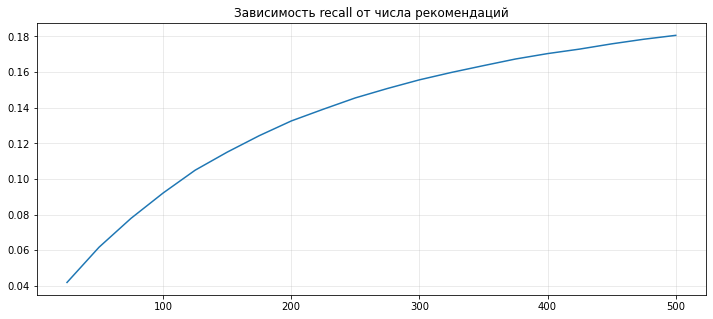

In [68]:
plt.figure(figsize=(12, 5))
plt.plot(res_dict.keys(), res_dict.values())
plt.grid(alpha=0.3)
plt.title('Зависимость recall от числа рекомендаций')
plt.show()

Как и следовало ожидать, полнота купленных товаров в рекомендованных увеличивается с ростом количества самих рекомендаций, однако максимально большие значения рекомендаций не будут являться оптимальными значениями, т.к. мы преследуем цель макимально снизить количество товаров, которые точно не будем рекомендовать, а поэтому для выбора оптимального значения для recall необходимо руководствоваться одним или совокупностью условий:
* текущая задача, для которой применяется предфильтрующая модель (она может быть практически финальной и в любом случае должна выдавать не тысячи рекомендаций, ...), должна соответстовать критерию расчета
* модель, для которой считаются рекомендации на этом этапе должна учиться на датасете за разумное количество времени
* количество рекомендация можно подбирать, исходя из вида графика recall к N_rec. Наиболее оптимальное значение может лежать на месте наибольшего перегиба графика

Если не учитывать первые 2 условия, можно предположить, что оптимальное значение предсказаний для расчета recall будет лежать в районе 150-200.


---

# 2

Создадим несколько признаков:

In [69]:
df_gr_basket = data_train_ranker.groupby('basket_id')[['quantity', 'sales_value']].sum().reset_index()
df_gr_basket.columns = ['basket_id', 'basket_quantity', 'basket_sales_value']
df_gr_basket

,basket_id,basket_quantity,basket_sales_value
0,40618492260,1,1.00
1,40618753059,12,28.48
2,40618809138,5,34.83
3,40618809139,5,6.58
4,40629515323,15,37.15
...,...,...,...
17037,41297771177,3,4.54
17038,41297771180,1,5.19
17039,41297772063,3,14.40
17040,41297772783,2,1.18


In [70]:
df_ranker_train_f = data_train_ranker.copy()
df_ranker_train_f = df_ranker_train_f.merge(df_gr_basket, on='basket_id', how='left')
df_ranker_train_f

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,basket_quantity,basket_sales_value
0,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0,1,1.00
1,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0,12,28.48
2,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0,12,28.48
3,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0,12,28.48
4,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0,12,28.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163256,222,41297772783,635,1120741,1,0.59,304,0.00,1716,91,0.0,0.0,2,1.18
163257,462,41297773713,635,993339,1,1.99,304,0.00,2040,91,0.0,0.0,4,10.07
163258,462,41297773713,635,995242,1,1.00,304,-0.89,2040,91,0.0,0.0,4,10.07
163259,462,41297773713,635,10180324,1,3.00,304,-0.29,2040,91,0.0,0.0,4,10.07


In [71]:
item_avg_sales_value = df_ranker_train_f.groupby('item_id')[['sales_value']].mean().reset_index()
item_avg_sales_value.columns = ['item_id', 'avg_item_sales_value']
item_avg_sales_value

,item_id,avg_item_sales_value
0,28116,0.33
1,28117,0.34
2,28143,0.33
3,28186,0.79
4,28304,0.53
...,...,...
27113,17381856,0.00
27114,17382205,7.99
27115,17383227,4.49
27116,17827644,2.50


In [72]:
user_avg_sales_value = df_ranker_train_f.groupby('user_id')[['sales_value']].mean().reset_index()
user_avg_sales_value.columns = ['user_id', 'avg_user_sales_value']
user_avg_sales_value

,user_id,avg_user_sales_value
0,1,2.569774
1,6,3.225490
2,7,2.085000
3,8,2.472683
4,9,3.250000
...,...,...
1910,2496,2.442676
1911,2497,3.504062
1912,2498,3.124407
1913,2499,3.157179


In [73]:
item_user_basket_count = df_ranker_train_f.groupby('item_id')[['basket_quantity']].mean().reset_index()
item_user_basket_count.columns = ['item_id', 'avg_basket_quantity']
item_user_basket_count

,item_id,avg_basket_quantity
0,28116,20.0
1,28117,20.0
2,28143,20.0
3,28186,53.0
4,28304,20.0
...,...,...
27113,17381856,84.0
27114,17382205,7.0
27115,17383227,34.0
27116,17827644,49.0


In [74]:
item_user_basket_sales_value = df_ranker_train_f.groupby('item_id')[['basket_sales_value']].mean().reset_index()
item_user_basket_sales_value.columns = ['item_id', 'avg_basket_sales_value']
item_user_basket_sales_value

,item_id,avg_basket_sales_value
0,28116,21.57
1,28117,21.57
2,28143,21.57
3,28186,49.97
4,28304,21.57
...,...,...
27113,17381856,408.28
27114,17382205,21.85
27115,17383227,149.58
27116,17827644,71.15


Объединим в один датафрейм:

In [75]:
df_ranker_train_f = df_ranker_train.\
    merge(item_avg_sales_value, on='item_id', how='left').\
    merge(user_avg_sales_value, on='user_id', how='left').\
    merge(item_user_basket_count, on='item_id', how='left').\
    merge(item_user_basket_sales_value, on='item_id', how='left')

df_ranker_train_f.fillna(0, inplace=True)
df_ranker_train_f

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_item_sales_value,avg_user_sales_value,avg_basket_quantity,avg_basket_sales_value
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,6.650000,3.025931,43.333333,107.726667
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,10.990000,3.025931,9.000000,56.610000
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.000000,3.025931,0.000000,0.000000
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.000000,3.025931,0.000000,0.000000
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,8.789000,3.025931,18.600000,63.788000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196360,1745,844179,0.0,2852,MEAT,National,BEEF,PRIMAL,,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,4.962558,4.656667,35.413953,73.584651
196361,1745,1126899,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,2.990028,4.656667,28.245014,68.499003
196362,1745,1044078,0.0,2845,MEAT,National,BEEF,LEAN,,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,4.747992,4.656667,34.308880,64.753243
196363,1745,1127831,0.0,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,4.584892,4.656667,35.194245,90.350144


In [76]:
X_train = df_ranker_train_f.drop('target', axis=1)
y_train = df_ranker_train_f[['target']]

cat_feats = X_train.columns[2:-4].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\Programs\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [77]:
df_ranker_predict = df_ranker_train.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [83]:
df_ranker_predict

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,proba_item_purchase
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.085520
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.010901
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.000514
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.000190
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.394548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196360,1745,844179,0.0,2852,MEAT,National,BEEF,PRIMAL,,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,0.064489
196361,1745,1126899,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,0.238548
196362,1745,1044078,0.0,2845,MEAT,National,BEEF,LEAN,,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,0.127408
196363,1745,1127831,0.0,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,0.059210


In [78]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


In [79]:
%%time
result_eval_ranker['own_rec_f'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 7.17 s


Переранжируем рекомеднации второй моделью и оценим результаты для precision@5:

In [106]:
def rerank(user_id, user_clm='user_id', proba_clm='proba_item_purchase', N=5):
    return df_ranker_predict[df_ranker_predict[user_clm]==user_id].sort_values(proba_clm, ascending=False).head(N).item_id.tolist()

In [110]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))
sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec_f', 0.1462140992167092), ('reranked_own_rec', 0.1260574412532627)]

Как видно, использование двухуровневой модели только ухудшило результат.